In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import relu
from torch.utils.data import DataLoader
from torchvision import datasets, models
import matplotlib.pyplot as plt
import numpy as np

### Data Path

In [5]:
train_path = '/Users/douglaszou/Downloads/fer2013/train'
test_path = '/Users/douglaszou/Downloads/fer2013/test'

### Data Transformation

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # upscale the 224 x 224 from 48 x 48
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Data loading

In [11]:
# Load datasets
trainset = datasets.ImageFolder(root=train_path, transform=transform)
testset = datasets.ImageFolder(root=test_path, transform=transform)

# Data loaders
batch_size = 16
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

### Display sample image batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


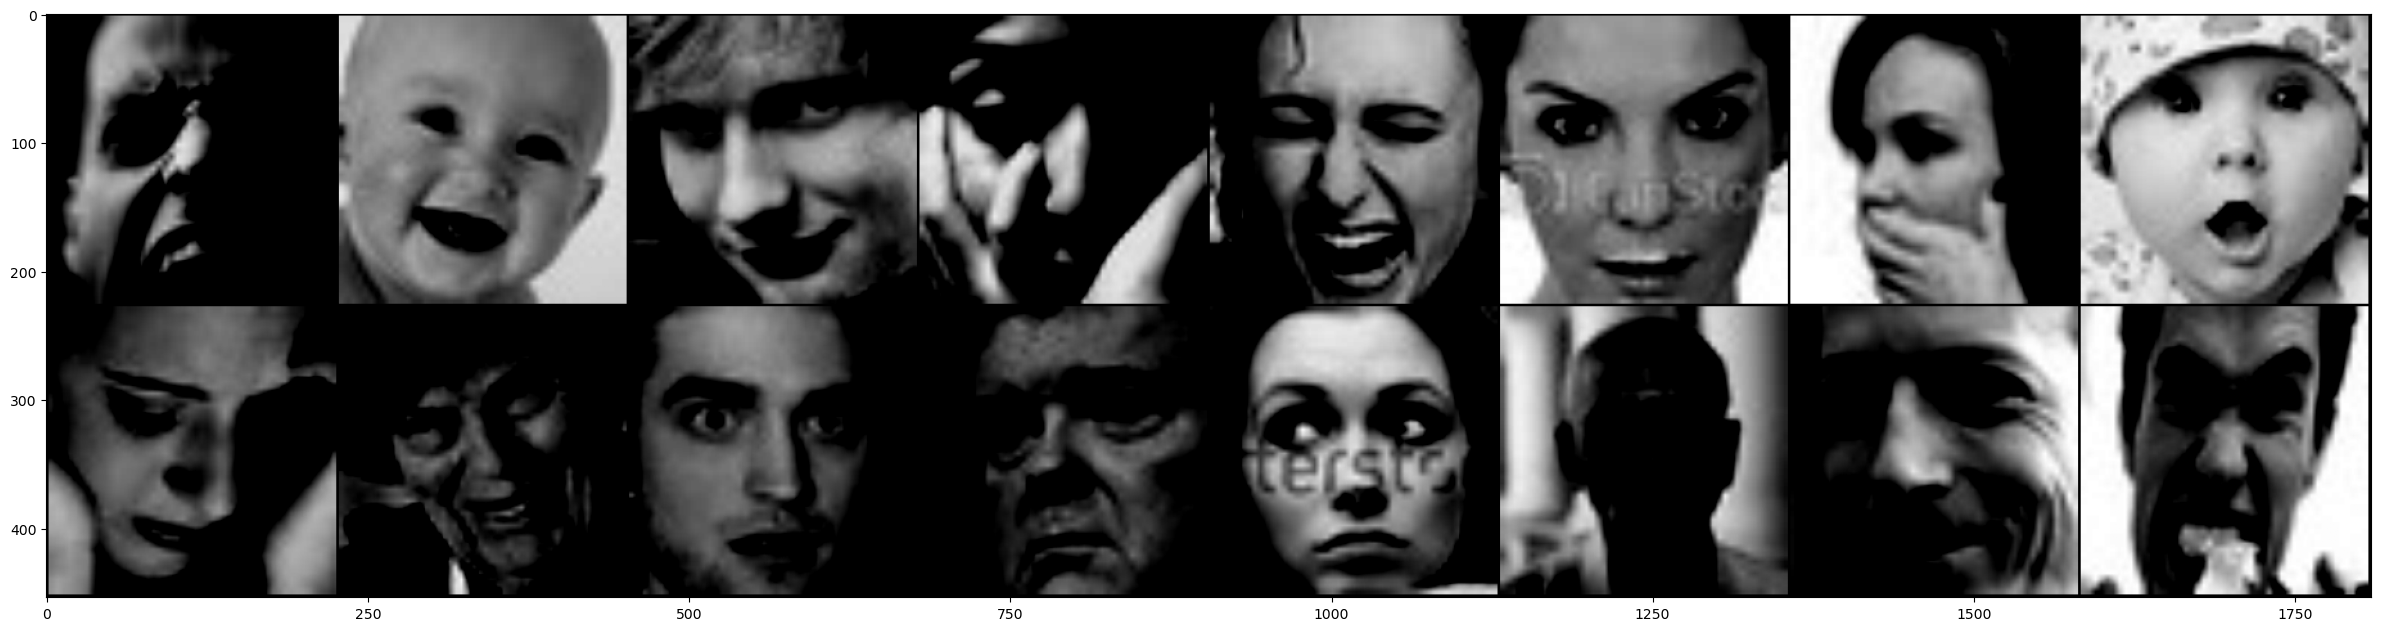

Fear | Happy | Sad | Fear | Angry | Neutral | Surprise | Neutral | Surprise | Sad | Neutral | Surprise | Surprise | Sad | Happy | Angry | 

In [14]:
# Display sample images
sample = next(iter(train_loader))
image, label = sample

grid = torchvision.utils.make_grid(image, nrow=8)
grid_np = grid.numpy()
grid_np = np.transpose(grid_np, (1, 2, 0))
plt.figure(figsize=(30, 30))
plt.imshow(grid_np)
plt.show()

results_label = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Show the result labels
for lb in label:
    print(results_label[int(lb)], end=" | ")

### Residual Block Definition

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

### Masking Mechanism Definition

In [22]:
class MaskingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MaskingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        mask = self.sigmoid(self.conv(x))
        out = x * mask
        return out

### Define RMN model

In [25]:
class RMN(nn.Module):
    def __init__(self, num_classes=7):
        super(RMN, self).__init__()
        self.layer1 = ResidualBlock(3, 64, stride=2)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.masking = MaskingBlock(256, 256)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.masking(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [32]:
# Model Initialization
model = RMN(num_classes=len(results_label))

### Move the model to GPU

In [42]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

RMN(
  (layer1): ResidualBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(64, 128, kernel_size=(

### Loss function and optimizer

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
# every 2 epochs, decrease the LR by 10%
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

### Model training

In [50]:
num_epochs = 10
tracked_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        tracked_losses.append(running_loss)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Step the scheduler
    # scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct/total}%')

Epoch [1/10], Loss: 1.1201202298605342, Accuracy: 57.93305235292069%
Epoch [2/10], Loss: 1.0765500657737752, Accuracy: 59.420390818210315%
Epoch [3/10], Loss: 1.026038669560281, Accuracy: 61.71583823887979%
Epoch [4/10], Loss: 0.9746385965008589, Accuracy: 63.82667456198405%
Epoch [5/10], Loss: 0.9138637462698318, Accuracy: 66.00020899369535%
Epoch [6/10], Loss: 0.8560156568511282, Accuracy: 68.44543522937057%
Epoch [7/10], Loss: 0.7867707002959876, Accuracy: 71.31213208401546%
Epoch [8/10], Loss: 0.7140566632276126, Accuracy: 74.25197673203525%
Epoch [9/10], Loss: 0.640463907497839, Accuracy: 76.95147863039465%
Epoch [10/10], Loss: 0.5685255338554595, Accuracy: 79.97143752830122%


In [56]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Display overall accuracy
print(f'Test Accuracy: {100 * correct/total}%')

Test Accuracy: 56.06018389523544%


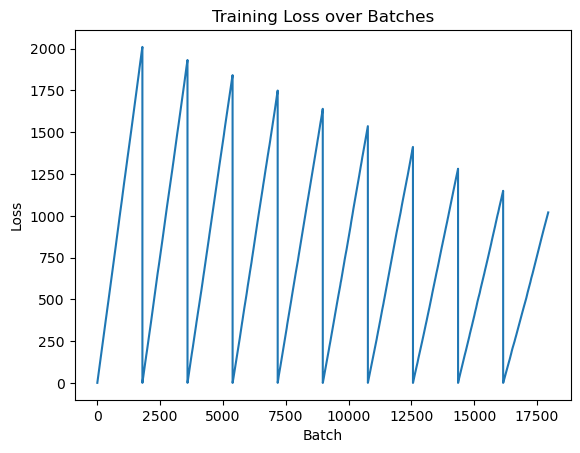

In [74]:
# Visualize batch losses
plt.plot(tracked_losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss over Batches')
plt.show()